In [2]:
import sys, os
os.environ['WANDB_NOTEBOOK_NAME'] = 'rbig_v2'
sys.path.append("/home/emmanuel/code/destructive-deep-learning")
# sys.path.append("/home/emmanuel/notebooks/jaxflows/scripts")

# from data import get_toy_data
# from visualize import plot_joint
from ddl.datasets import make_toy_data
from ddl.univariate import HistogramUnivariateDensity
from ddl.independent import (
    IndependentInverseCdf,
    IndependentDensity,
    IndependentDestructor,
)
from ddl.linear import LinearProjector
from ddl.base import CompositeDestructor
from ddl.deep import DeepDestructor, DeepDestructorCV
from sklearn.decomposition import PCA
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# config parameters
n_samples = 10_000
dataset = "classic"
bins = "auto"  # bin estimation (uses automatric method)
bounds = 0.1  # percentage extension of the support
alpha = 1e-10  # regularization parameter for hist


### Data

In [4]:
def get_toy_data(n_samples=1000, seed=123):
    rng = np.random.RandomState(seed=seed)

    x = np.abs(2 * rng.randn(n_samples, 1))
    y = np.sin(x) + 0.25 * rng.randn(n_samples, 1)
    data = np.hstack((x, y))

    return data


## Plots

In [5]:
def plot_joint(
    data: np.ndarray, color: str = "red", title: str = "", kind="kde", logger=None
):

    plt.figure()
    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

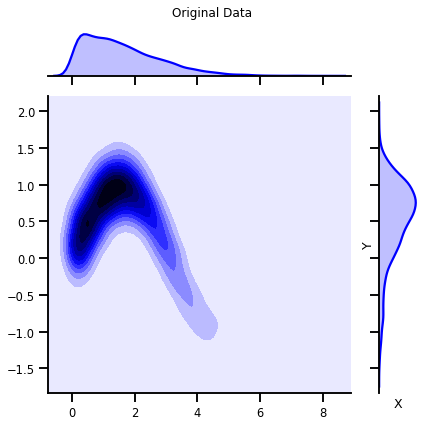

In [6]:
data = get_toy_data(n_samples=n_samples)


plot_joint(data, "blue", "Original Data")

## Deep Destructor

This is where we put everything in one block and add multiple layers.

In [7]:
%%time
from ddl.deep import DeepDestructorStop
# ==================================
# Step I - Marginal Uniformization
# ==================================
# Choose the Histogram estimator that converts the data X to uniform U(0,1)
univariate_estimator = HistogramUnivariateDensity(
    bounds=0.1, bins="auto", alpha=1e-5
)

# Marginally uses histogram estimator
marginal_uniformization = IndependentDensity(
    univariate_estimators=univariate_estimator
)

# Creates "Destructor" D_theta_1
uniform_density = IndependentDestructor(marginal_uniformization)

# ===================================
# Step II - Marginal Gaussianization
# ===================================

# Choose destructor D_theta_2 that converts data
marginal_gaussianization = IndependentInverseCdf()

# ======================================
# Step III - Rotation
# ======================================

# Choose a linear projection to rotate the features (PCA) "D_theta_3"
rotation = LinearProjector(linear_estimator=PCA(random_state=123))

# ======================================
# All Steps - Deep Density Destructor
# ======================================
# rbig_block = CompositeDestructor(
#     destructors=
# )
rbig_flow = DeepDestructorStop(
    canonical_destructor=[uniform_density, marginal_gaussianization, rotation],
    base_dist="gaussian", 
    tol_layers=15,
    threshhold=0.25,
    stopping_crit="info",
)



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 111 µs


In [8]:
%%time
rbig_flow = DeepDestructorStop(
    canonical_destructor=[uniform_density, marginal_gaussianization, rotation],
    base_dist="gaussian", 
    tol_layers=15,
    threshhold=0.25,
    stopping_crit="max",
    max_layers=100
)


data = get_toy_data(n_samples=10_000, seed=123)

# Fit and transform data G_z ----> R (G_z)
G_approx = rbig_flow.fit_transform(data)

CPU times: user 44.2 s, sys: 5.49 s, total: 49.7 s
Wall time: 1.83 s


In [9]:
rbig_flow.n_layers

100

In [10]:
nll = rbig_flow.score(data)
print(f"Negative Log-Likelihood Score: {nll:.4f}")

Negative Log-Likelihood Score: -2.6680


<Figure size 432x288 with 0 Axes>

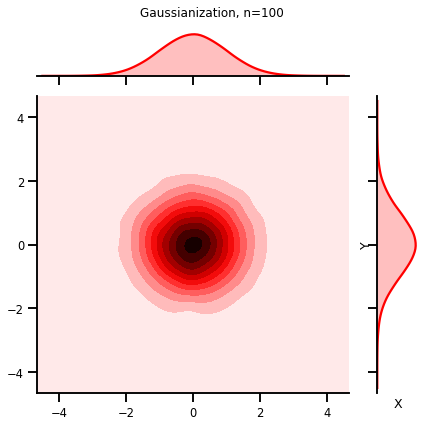

In [11]:
plot_joint(G_approx, "red", title=f"Gaussianization, n={rbig_flow.n_layers}")

## Loss - $\Delta$ Total Correlation

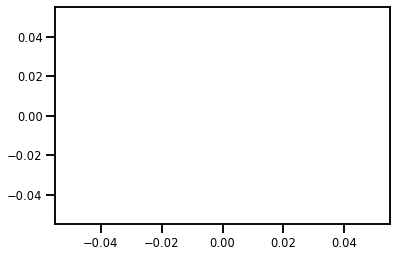

In [12]:
plt.plot(rbig_flow.loss)

### Negative Log-Likelihood

In [13]:
from ddl.stopping import negative_log_likelihood

In [14]:
rbig_flow.fit(data)

Z = data.copy()

nll_loss = []
nongauss_loss = []

X_ldj = np.zeros(Z.shape[0])
for i, iblock in enumerate(rbig_flow.fitted_destructors_):
    
    
    Z = iblock.transform(Z)
        
    # calculate the negative log-likelihood
    if (i+1) % 3 == 0:
        
#         plot_joint(Z, "red", title=f"Gaussianization, n={(i+1)//3}")
        # add nll_loss
        X_ldj = iblock.score_samples(Z)
        nll_loss.append(negative_log_likelihood(Z, X_ldj[:, np.newaxis]))


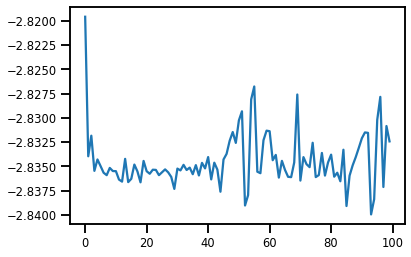

In [15]:
plt.plot(nll_loss)

### Non-Gaussianity

In [16]:
from ddl.stopping import diff_negentropy
from functools import partial

In [17]:
%%time
rbig_flow = DeepDestructorStop(
    canonical_destructor=[uniform_density, marginal_gaussianization, rotation],
    base_dist="uniform", 
    tol_layers=15,
    threshhold=0.25,
    stopping_crit="info"
)



rbig_flow.fit(data)

Z = data.copy()

nongauss_loss = []

X_ldj = np.zeros(Z.shape[0])
for i, iblock in enumerate(rbig_flow.fitted_destructors_):
    f = partial(diff_negentropy, Z=Z)
    
    
    Z = iblock.transform(Z)
    
        
    # calculate the negative log-likelihood
    if (i+1) % 3 == 0:
        
        # calculate the logdetjacobian of transformation
        X_ldj += iblock.score_samples(Z)
        # add non-Gaussianity
        nongauss_loss.append(f(X=Z, X_slogdet=X_ldj[:, np.newaxis]))
        
    f = partial(diff_negentropy, Z=Z)

CPU times: user 19.5 s, sys: 2.4 s, total: 21.9 s
Wall time: 835 ms


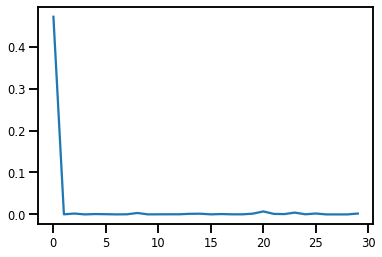

In [105]:
plt.plot(nongauss_loss)